In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import os, sys
import glob
import numpy as np
import torch
import pandas as pd
import random
import torch.nn as nn
import pickle
import torch.nn.functional as F
import scipy.stats
from scipy.stats import binom
from matplotlib import pyplot as plt

In [3]:
from mstcn_model import *
from utility.adaptive_data_loader import Breakfast, collate_fn_override
from utils import calculate_mof, dotdict

In [4]:
os.environ["WANDB_API_KEY"] = "992b3b1371ba79f48484cfca522b3786d7fa52c2"
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dipika_singhania (use `wandb login --relogin` to force relogin)


True

In [5]:
seed = 42

# Ensure deterministic behavior
def set_seed():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
set_seed()

# Device configuration
os.environ['CUDA_VISIBLE_DEVICES']='0'
# os.environ['CUDA_LAUNCH_BLOCKING']='6'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
config = dotdict(
    epochs=500,
    num_class=48,
    batch_size=8,
    learning_rate=5e-4,
    weight_decay=0,
    dataset="Breakfast",
    architecture="unet-ensemble",
    features_file_name="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/",
    chunk_size=1,
    max_frames_per_video=1200,
    feature_size=2048,
    ground_truth_files_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/",
    label_id_csv="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv",
    gamma=0.1,
    step_size=500,
    split=2,
#     output_dir="/mnt/data/ar-datasets/dipika/breakfast/ms_tcn/data/breakfast/results/unsuper-finetune-split2-0.05-data-llr/",
    output_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-mstcn-weaksup-split2/",
    project_name="breakfast-split-2",
    train_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split{}.bundle",
    test_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split{}.bundle",
    all_files="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt",
    cutoff=8,
    data_per = 0.2,
    budget=40,
    semi_supervised_split="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/semi_supervised/train.split{}_amt{}.bundle")

config.train_split_file = config.train_split_file.format(config.split)
config.semi_supervised_split = config.semi_supervised_split.format(config.split, config.data_per)
config.test_split_file = config.test_split_file.format(config.split)

if not os.path.exists(config.output_dir):
    os.mkdir(config.output_dir)

train_split_file_list = set(open(config.train_split_file).read().split("\n")[0:-1])
print(config)

{'epochs': 500, 'num_class': 48, 'batch_size': 8, 'learning_rate': 0.0005, 'weight_decay': 0, 'dataset': 'Breakfast', 'architecture': 'unet-ensemble', 'features_file_name': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/', 'chunk_size': 1, 'max_frames_per_video': 1200, 'feature_size': 2048, 'ground_truth_files_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/', 'label_id_csv': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv', 'gamma': 0.1, 'step_size': 500, 'split': 2, 'output_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-mstcn-weaksup-split2/', 'project_name': 'breakfast-split-2', 'train_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split2.bundle', 'test_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split2.bundle', 'all_files': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt', 'cutoff': 8, 'data_per': 0.2, 'budget': 40, 'semi_supervised_split': 

In [7]:
traindataset = Breakfast(config, fold='train', fold_file_name=config.train_split_file)
testdataset = Breakfast(config, fold='test', fold_file_name=config.test_split_file)

Number of videos logged in train fold is 1261
Number of videos not found in train fold is 0
Number of videos logged in test fold is 451
Number of videos not found in test fold is 0


In [8]:
def _init_fn(worker_id):
    np.random.seed(int(seed))
trainloader = torch.utils.data.DataLoader(dataset=traindataset,
                                          batch_size=config.batch_size, 
                                          shuffle=True,
                                          pin_memory=True, num_workers=4, 
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)
testloader = torch.utils.data.DataLoader(dataset=testdataset,
                                          batch_size=config.batch_size, 
                                          shuffle=False,
                                          pin_memory=True, num_workers=4,
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)

In [9]:
# item = iter(trainloader).next()
# print(item[0]) # -- data feature
# print(item[1]) # -- valid count
# item[2] # -- Actual labels
# print(item[5]) # video names
# video_id_boundary_frames

In [10]:
loaded_vidid_selected_frames = np.load("/home/dipika16/ar/TimestampActionSeg/data/breakfast_annotation_all.npy", 
                                       allow_pickle=True).item()

video_id_boundary_frames = pickle.load(open("data/breakfast_boundary_annotations.pkl", "rb"))
video_id_boundary_frames = dict([(key[:-4], val) for key,val in video_id_boundary_frames.items()])

weak_labels = pickle.load(open('data/breakfast_weaklysupervised_labels.pkl', 'rb'))
weak_labels = dict([(key[:-4], val) for key,val in weak_labels.items()])

loaded_mean_var_actions = pickle.load(open("data/breakfast_meanvar_actions.pkl", "rb"))

with open('/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/len_video.txt', 'r') as openf:
    attributes = [item.strip().split()[::-1] for item in openf.readlines()]
frame_id_dict = dict([(vidid[:-4], int(framecount)) for vidid,framecount in attributes])

df=pd.read_csv(config.label_id_csv)
label_id_to_label_name = {}
label_name_to_label_id_dict = {}
for i, ele in df.iterrows():
    label_id_to_label_name[ele.label_id] = ele.label_name
    label_name_to_label_id_dict[ele.label_name] = ele.label_id

In [11]:
# weak_labels, loaded_mean_var_actions

In [12]:
posterior_table = {}
prior_table = {}

In [13]:
# pickle.dump(prior_table, open('data/breakfast_lengthmodel_multinomial_prior.pkl', 'wb'))

In [14]:
# for ele in weak_labels.keys():
#     frame_count = frame_id_dict[ele]
#     label_list = weak_labels[ele]
#     mean_list = np.array([loaded_mean_var_actions[label][0] for label in label_list])
#     total_mean = np.sum(mean_list)
#     left_sum = np.cumsum(mean_list)
#     relative_sum = left_sum / total_mean
#     prob_id_ge_boundary = [binom.cdf(np.arange(frame_count)+1, frame_count, rel) for rel in relative_sum]
#     prob_id_gt_boundary = [1] + [cdf - binom.pmf(np.arange(frame_count)+1, 
#                                                  frame_count,
#                                                  rel) for rel,cdf in zip(relative_sum, prob_id_ge_boundary)]
#     prob_id_gt_boundary[-1] = 0
#     prior_table[ele] = np.stack([prob_id_gt_boundary[j-1] - prob_id_gt_boundary[j] 
#                                     for j in range(1,len(label_list)+1)], axis=0)

prior_table = pickle.load(open('data/breakfast_lengthmodel_multinomial_prior.pkl', 'rb'))

In [240]:
def generate_posterior_loss_weights(framewise_proba, ele):
    '''
    ele is video_id
    '''
    global posterior_table
    frame_count = frame_id_dict[ele]
    label_list = [label_name_to_label_id_dict[item] for item in weak_labels[ele]]
    seqlen = len(label_list)
    label_seq_prob = framewise_proba[:frame_count,label_list]
    label_seq_logprob = torch.log(label_seq_prob + 1e-10)

    left_probsum = torch.cumsum(label_seq_prob, dim=1)
    right_probsum = torch.sum(label_seq_prob, dim=1, keepdim=True) - torch.cumsum(label_seq_prob, dim=1) + label_seq_prob

    left_logprobsum = torch.log(torch.clip(left_probsum, min=1e-20))
    right_logprobsum = torch.log(torch.clip(right_probsum, min=1e-20))

    left_logprobsum_left_idsum = torch.cumsum(left_logprobsum, dim=0)
    left_logprobsum_left_idsum -= left_logprobsum
    right_logprobsum_right_idsum = torch.sum(right_logprobsum, dim=0, keepdim=True) - torch.cumsum(right_logprobsum, dim=0)

    for k in range(seqlen):
        left_logprobsum_left_idsum[:k,k] = -1000
        remaining_labelcount = seqlen-k-1
        if remaining_labelcount > 0:
            right_logprobsum_right_idsum[-remaining_labelcount:,k] = -1000

    loglikelihood = label_seq_logprob + 10*(left_logprobsum_left_idsum + right_logprobsum_right_idsum)/(frame_count)
    posterior = loglikelihood.T + torch.log(torch.clip(torch.tensor(prior_table[ele]), min=1e-10))/10
    posterior = torch.softmax(posterior/2, dim=0)
    posterior_table[ele] = posterior

In [241]:
def get_estimated_boundaries():
    estimated_boundary_dict = {}
    for ele in weak_labels.keys():
        if (ele + ".txt") not in train_split_file_list:
            continue
        else:
            frame_count = frame_id_dict[ele]
            label_list = [label_name_to_label_id_dict[item] for item in weak_labels[ele]]
            posterior_id_between_boundary = posterior_table[ele]

            prob_boundary_le_id = 1 - np.cumsum(posterior_id_between_boundary, axis=0)
            prob_boundary_le_id = np.concatenate([np.zeros((len(label_list), 1)), prob_boundary_le_id], axis=1)
            frame_wise_proba = prob_boundary_le_id[:,1:] - prob_boundary_le_id[:,:-1]
#             import pdb
#             pdb.set_trace()
            estimated_boundary_dict[ele] = np.sum(frame_wise_proba * np.arange(frame_count), axis=1)[:-1]
            
    return estimated_boundary_dict

In [210]:
def get_estimated_loss(data_feat, data_count, video_ids, labels_all): #, loaded_vidid_selected_frames, boundaries_dict):
    global posterior_table
    loss_arr = []
    device = data_feat.device
    for iter_num in range(len(data_count)):
        ele = video_ids[iter_num]
        frame_count = frame_id_dict[ele]
        label_list = [label_name_to_label_id_dict[item] for item in weak_labels[ele]]
        label_list = torch.tensor(label_list).type(torch.long).to(device)
        label_seq_logprob = torch.log(data_feat[iter_num][:frame_count, label_list] + 1e-10)
        weights = posterior_table[ele].to(device).T
        weighted_loss = torch.sum(weights * label_seq_logprob, dim=1)
        loss_arr.append(weighted_loss)
    return -torch.mean(torch.cat(loss_arr)), loss_arr

In [211]:
def get_boundary_err():
    err_list = []
    correct = 0.0
    total = 0.0
    estimated_boundary_dict = get_estimated_boundaries()
    for ele in video_id_boundary_frames.keys():
        if ele + ".txt" not in train_split_file_list:
            continue
        estimated_boundary_list = estimated_boundary_dict[ele]

        estimated = np.array(estimated_boundary_list) #.detach().cpu().numpy()
        if np.isnan(estimated).any():
            print(ele)
        actual = np.array(video_id_boundary_frames[ele][:-1])
        if len(actual) != len(estimated):
            print(ele)
            continue

        mse_err = (actual - estimated)**2
        err_list.append(mse_err)

    print(f"Train Boundary avergage error = {np.sqrt(np.mean(np.concatenate(err_list))):.3f}")

In [213]:
pseudo_labels_dir = "/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/length_segmentation_output/"
def get_single_random(output_p, video_ids):
    # Generate target for only timestamps. Do not generate pseudo labels at first 30 epochs.
    boundary_target_tensor = torch.ones((output_p.shape[0], output_p.shape[2]), dtype=torch.long, 
                                        device=output_p.device) * (-100)
    for iter_num, cur_vidid in enumerate(video_ids):
        pseudo_l = open(pseudo_labels_dir + cur_vidid + ".txt").read().split("\n")[0:-1]
        pseudo_l = [label_name_to_label_id_dict[ele] for ele in pseudo_l]
        abc = torch.tensor(pseudo_l).to(torch.long).to(boundary_target_tensor.device)
        frame_idx_tensor = torch.arange(0, len(pseudo_l), 1).to(device)
        boundary_target_tensor[iter_num, frame_idx_tensor] = abc

    return boundary_target_tensor

In [220]:
set_seed()
model = MultiStageModel(num_stages=4, num_layers=10, num_f_maps=64, dim=2048, num_classes=48).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Requires loaded_vidid_selected_frames, boundaries_dict
ce_criterion = nn.CrossEntropyLoss(ignore_index=-100)
mse_criterion = nn.MSELoss(reduction='none')

In [221]:
loaded_file=torch.load(f"/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-lenassum-mstcn-split2-slup15/"
                       f"ms-tcn-initial-25-epochs.wt")
model.load_state_dict(loaded_file)

<All keys matched successfully>

In [242]:
model.eval()
print("Calculating Expectation")
correct = 0.0
total = 0.0

for i, item in enumerate(trainloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)
        prob = torch.softmax(predictions[-1], dim=1)
        prob = prob.permute(0, 2, 1)
        for j in range(len(prob)):
            generate_posterior_loss_weights(prob[j].cpu(), item[4][j])

        if i % 20 == 0:
            print(f"Iter {i}")

get_boundary_err()

print("Calculating Validation Data Accuracy")
correct = 0.0
total = 0.0
for i, item in enumerate(testloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)

        pred = torch.argmax(predictions[-1], dim=1)
        correct += float(torch.sum((pred == item_2) * src_mask).item())
        total += float(torch.sum(src_mask).item())
val_acc = correct * 100.0 / total
print(f"Validation:: Probability Accuracy {val_acc}")

Calculating Expectation
Iter 0
Iter 20
Iter 40
Iter 60
Iter 80
Iter 100
Iter 120
Iter 140
Train Boundary avergage error = 281.776
Calculating Validation Data Accuracy
Validation:: Probability Accuracy 54.12302688817997


In [243]:
initialize_epoch = 25
expectation_cal_gap = 5
best_val_acc = 0
for epoch in range(26, 1000):
    print("Starting Training")
    model.train()
    for i, item in enumerate(trainloader):
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)
        optimizer.zero_grad()
        
        middle_pred, predictions = model(item_0, src_mask_mse)
        psuedo_l = get_single_random(predictions[-1], item[4])
        
        loss = 0
        for p in predictions:
            if epoch <= initialize_epoch:
                loss += ce_criterion(p, psuedo_l)
                loss += 0.15 * torch.mean(torch.clamp(mse_criterion(F.log_softmax(p[:, :, 1:], dim=1), 
                                                                    F.log_softmax(p.detach()[:, :, :-1], dim=1)), min=0,
                                            max=16) * src_mask_mse[:, :, 1:])
            else:
                prob = torch.softmax(p, dim=1)
                prob = prob.permute(0, 2, 1)
                es_loss, _ = get_estimated_loss(prob, item_1, item[4], item_2)
                loss += es_loss
            
        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            with torch.no_grad():
                pred = torch.argmax(predictions[-1], dim=1)
                correct = float(torch.sum((pred == item_2) * src_mask).item())
                total = float(torch.sum(src_mask).item())
                print(f"Training:: Epoch {epoch}, Iteration {i}, Current loss {loss.item()}" +
                      f" Accuracy {correct * 100.0 / total}")
    if epoch == initialize_epoch:
        torch.save(model.state_dict(), config.output_dir + "ms-tcn-initial-15-epochs.wt")
    # Calculating Expectation Step
    model.eval()
    if (epoch >= initialize_epoch) and (epoch % expectation_cal_gap == 0):
        print("Calculating Expectation")
        correct = 0.0
        total = 0.0

        for i, item in enumerate(trainloader):
            with torch.no_grad():
                item_0 = item[0].to(device)
                item_1 = item[1].to(device)
                item_2 = item[2].to(device)
                src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
                src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

                middle_pred, predictions = model(item_0, src_mask_mse)
                prob = torch.softmax(predictions[-1], dim=1)
                prob = prob.permute(0, 2, 1)
                for j in range(len(prob)):
                    generate_posterior_loss_weights(prob[j].cpu(), item[4][j])
                
                if i % 20 == 0:
                    print(f"Epoch {epoch} iter {i}")
                    
        get_boundary_err()

    print("Calculating Validation Data Accuracy")
    correct = 0.0
    total = 0.0
    for i, item in enumerate(testloader):
        with torch.no_grad():
            item_0 = item[0].to(device)
            item_1 = item[1].to(device)
            item_2 = item[2].to(device)
            src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
            src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

            middle_pred, predictions = model(item_0, src_mask_mse)

            pred = torch.argmax(predictions[-1], dim=1)
            correct += float(torch.sum((pred == item_2) * src_mask).item())
            total += float(torch.sum(src_mask).item())
    val_acc = correct * 100.0 / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), config.output_dir + "ms-tcn-emmax-best-model-fulllikelihood.wt")
    torch.save(model.state_dict(), config.output_dir + "ms-tcn-emmax-last-model-fulllikelihood.wt")
    print(f"Validation:: Epoch {epoch}, Probability Accuracy {val_acc}")

Starting Training
Training:: Epoch 26, Iteration 0, Current loss 1.1014490821535248 Accuracy 61.711366538952745
Training:: Epoch 26, Iteration 10, Current loss 0.9540314441316906 Accuracy 56.52804361695957
Training:: Epoch 26, Iteration 20, Current loss 1.0059737414446723 Accuracy 58.27196858124693
Training:: Epoch 26, Iteration 30, Current loss 1.220347220312781 Accuracy 55.70423506690578
Training:: Epoch 26, Iteration 40, Current loss 1.0495563370419834 Accuracy 66.41489777314754
Training:: Epoch 26, Iteration 50, Current loss 0.9403711788906621 Accuracy 60.71033630390945
Training:: Epoch 26, Iteration 60, Current loss 0.915465453595571 Accuracy 51.49214383633871
Training:: Epoch 26, Iteration 70, Current loss 0.8881783782066778 Accuracy 67.03833045819835
Training:: Epoch 26, Iteration 80, Current loss 0.9958168625473743 Accuracy 62.61819213313162
Training:: Epoch 26, Iteration 90, Current loss 1.0924898720491496 Accuracy 66.01808714716361
Training:: Epoch 26, Iteration 100, Current 

Validation:: Epoch 30, Probability Accuracy 52.91834113601524
Starting Training
Training:: Epoch 31, Iteration 0, Current loss 1.0626853960928626 Accuracy 61.44437486954707
Training:: Epoch 31, Iteration 10, Current loss 1.183922657159757 Accuracy 57.25079654073737
Training:: Epoch 31, Iteration 20, Current loss 1.2892270143407643 Accuracy 52.404115996258184
Training:: Epoch 31, Iteration 30, Current loss 1.1586382990041377 Accuracy 63.421235253296324
Training:: Epoch 31, Iteration 40, Current loss 1.138720157168596 Accuracy 56.26116678318962
Training:: Epoch 31, Iteration 50, Current loss 1.1698610412613697 Accuracy 61.05579685933846
Training:: Epoch 31, Iteration 60, Current loss 1.1050720021402158 Accuracy 73.29775947076078
Training:: Epoch 31, Iteration 70, Current loss 1.1062357854259228 Accuracy 61.29799180535181
Training:: Epoch 31, Iteration 80, Current loss 1.0944406808590248 Accuracy 77.49369823550595
Training:: Epoch 31, Iteration 90, Current loss 1.0424536718724744 Accuracy

Training:: Epoch 36, Iteration 100, Current loss 1.4214537931357911 Accuracy 64.90652861662353
Training:: Epoch 36, Iteration 110, Current loss 1.1281257763150394 Accuracy 58.58538543897216
Training:: Epoch 36, Iteration 120, Current loss 1.4426095170162478 Accuracy 46.77155264469282
Training:: Epoch 36, Iteration 130, Current loss 1.293625877013866 Accuracy 58.7297792652801
Training:: Epoch 36, Iteration 140, Current loss 1.1036568037811159 Accuracy 70.46768531901714
Training:: Epoch 36, Iteration 150, Current loss 1.0619819562648616 Accuracy 63.06132707774799
Calculating Validation Data Accuracy
Validation:: Epoch 36, Probability Accuracy 55.346045490326055
Starting Training
Training:: Epoch 37, Iteration 0, Current loss 1.4956295283052707 Accuracy 59.235849056603776
Training:: Epoch 37, Iteration 10, Current loss 1.3613786315943064 Accuracy 66.31840008442826
Training:: Epoch 37, Iteration 20, Current loss 1.6420109843460846 Accuracy 51.90009303657053
Training:: Epoch 37, Iteration 3

Training:: Epoch 41, Iteration 90, Current loss 1.4001638725550327 Accuracy 65.27067767728404
Training:: Epoch 41, Iteration 100, Current loss 1.1094283569141898 Accuracy 73.87615092977072
Training:: Epoch 41, Iteration 110, Current loss 1.4256904437177083 Accuracy 74.46517979062358
Training:: Epoch 41, Iteration 120, Current loss 1.181650136603363 Accuracy 70.22713321055862
Training:: Epoch 41, Iteration 130, Current loss 1.7163616873932606 Accuracy 63.77010750949802
Training:: Epoch 41, Iteration 140, Current loss 1.3566564220607669 Accuracy 53.65444912963564
Training:: Epoch 41, Iteration 150, Current loss 1.356553059241037 Accuracy 70.23090586145648
Calculating Validation Data Accuracy
Validation:: Epoch 41, Probability Accuracy 55.17711397439616
Starting Training
Training:: Epoch 42, Iteration 0, Current loss 1.4301478412586066 Accuracy 57.96012915906219
Training:: Epoch 42, Iteration 10, Current loss 1.5030271697029491 Accuracy 60.48475693490799
Training:: Epoch 42, Iteration 20,

Training:: Epoch 46, Iteration 80, Current loss 1.2788883108993612 Accuracy 63.4454659423318
Training:: Epoch 46, Iteration 90, Current loss 1.3013613250745968 Accuracy 68.47122082365881
Training:: Epoch 46, Iteration 100, Current loss 1.2724879882624978 Accuracy 73.76103190767142
Training:: Epoch 46, Iteration 110, Current loss 1.2754800350000854 Accuracy 65.96181081213068
Training:: Epoch 46, Iteration 120, Current loss 1.5873455592675971 Accuracy 62.62128201049785
Training:: Epoch 46, Iteration 130, Current loss 1.5922989463952872 Accuracy 58.94777513040118
Training:: Epoch 46, Iteration 140, Current loss 1.2707947802633808 Accuracy 71.1438063597532
Training:: Epoch 46, Iteration 150, Current loss 1.5449731244494804 Accuracy 58.902199731488174
Calculating Validation Data Accuracy
Validation:: Epoch 46, Probability Accuracy 53.83529436135394
Starting Training
Training:: Epoch 47, Iteration 0, Current loss 1.0668766129686518 Accuracy 63.96032329169728
Training:: Epoch 47, Iteration 10

Training:: Epoch 51, Iteration 70, Current loss 1.4754982789641145 Accuracy 57.957846130930214
Training:: Epoch 51, Iteration 80, Current loss 1.438861078923034 Accuracy 74.34673366834171
Training:: Epoch 51, Iteration 90, Current loss 1.3954897508777593 Accuracy 73.1957600360848
Training:: Epoch 51, Iteration 100, Current loss 1.521165946425505 Accuracy 63.94140141110572
Training:: Epoch 51, Iteration 110, Current loss 1.4577723675459644 Accuracy 70.94159713945173
Training:: Epoch 51, Iteration 120, Current loss 1.215636334534329 Accuracy 71.34769035398698
Training:: Epoch 51, Iteration 130, Current loss 1.6524516026085823 Accuracy 63.74384236453202
Training:: Epoch 51, Iteration 140, Current loss 1.293335359138548 Accuracy 66.5706948875574
Training:: Epoch 51, Iteration 150, Current loss 1.05488656014683 Accuracy 71.35678391959799
Calculating Validation Data Accuracy
Validation:: Epoch 51, Probability Accuracy 51.22063636740274
Starting Training
Training:: Epoch 52, Iteration 0, Curr

Training:: Epoch 56, Iteration 60, Current loss 1.4936496192178308 Accuracy 72.73447951246098
Training:: Epoch 56, Iteration 70, Current loss 1.4993396360078568 Accuracy 69.73164258330875
Training:: Epoch 56, Iteration 80, Current loss 1.3970054289851066 Accuracy 61.41932141932142
Training:: Epoch 56, Iteration 90, Current loss 1.329755921555375 Accuracy 68.71928990331273
Training:: Epoch 56, Iteration 100, Current loss 1.1575411920140142 Accuracy 73.4373265238148
Training:: Epoch 56, Iteration 110, Current loss 1.3329033552462883 Accuracy 61.29217591141753
Training:: Epoch 56, Iteration 120, Current loss 1.2846153678225911 Accuracy 67.51760059527217
Training:: Epoch 56, Iteration 130, Current loss 1.5487002781274537 Accuracy 63.066202090592334
Training:: Epoch 56, Iteration 140, Current loss 1.2625483642235467 Accuracy 57.97618553707007
Training:: Epoch 56, Iteration 150, Current loss 1.381593306719861 Accuracy 63.5500614670127
Calculating Validation Data Accuracy
Validation:: Epoch 5

Training:: Epoch 61, Iteration 50, Current loss 1.7230975114753446 Accuracy 55.31174549069734
Training:: Epoch 61, Iteration 60, Current loss 1.5233012782378776 Accuracy 78.09562729873315
Training:: Epoch 61, Iteration 70, Current loss 1.416407017666774 Accuracy 65.06977490242207
Training:: Epoch 61, Iteration 80, Current loss 1.4485983337273924 Accuracy 66.66342128322461
Training:: Epoch 61, Iteration 90, Current loss 1.5125014814280144 Accuracy 66.37786748055528
Training:: Epoch 61, Iteration 100, Current loss 1.6414887574575452 Accuracy 61.65214461079285
Training:: Epoch 61, Iteration 110, Current loss 1.3516127504605877 Accuracy 61.048546644346374
Training:: Epoch 61, Iteration 120, Current loss 1.5260754936686634 Accuracy 67.35709326544782
Training:: Epoch 61, Iteration 130, Current loss 1.6144277453800675 Accuracy 57.14637752587482
Training:: Epoch 61, Iteration 140, Current loss 1.5650051333811934 Accuracy 57.317161215796695
Training:: Epoch 61, Iteration 150, Current loss 1.354

Training:: Epoch 66, Iteration 40, Current loss 1.2382077325094163 Accuracy 65.70276299982838
Training:: Epoch 66, Iteration 50, Current loss 1.4076736898253008 Accuracy 58.13700177505245
Training:: Epoch 66, Iteration 60, Current loss 1.4902532034189133 Accuracy 62.79683377308707
Training:: Epoch 66, Iteration 70, Current loss 1.374709933877884 Accuracy 71.96296069172747
Training:: Epoch 66, Iteration 80, Current loss 1.5395019351330337 Accuracy 50.08027113806636
Training:: Epoch 66, Iteration 90, Current loss 1.4658467826875645 Accuracy 56.03530534351145
Training:: Epoch 66, Iteration 100, Current loss 1.1075956534585698 Accuracy 66.44353441486848
Training:: Epoch 66, Iteration 110, Current loss 1.418234542505004 Accuracy 59.693537641572284
Training:: Epoch 66, Iteration 120, Current loss 1.4125878619670456 Accuracy 70.07865646258503
Training:: Epoch 66, Iteration 130, Current loss 1.2954632684325802 Accuracy 71.97683262154098
Training:: Epoch 66, Iteration 140, Current loss 1.534447

Training:: Epoch 71, Iteration 30, Current loss 1.2515707999808747 Accuracy 63.71251013239665
Training:: Epoch 71, Iteration 40, Current loss 1.371655434006976 Accuracy 66.63201094391245
Training:: Epoch 71, Iteration 50, Current loss 1.6821321220462198 Accuracy 56.90411283631622
Training:: Epoch 71, Iteration 60, Current loss 1.4475517778594158 Accuracy 61.04277482269504
Training:: Epoch 71, Iteration 70, Current loss 1.6482858240814457 Accuracy 61.304923824243765
Training:: Epoch 71, Iteration 80, Current loss 1.5037849875686573 Accuracy 58.78277153558052
Training:: Epoch 71, Iteration 90, Current loss 1.2708476099899602 Accuracy 62.03420207602121
Training:: Epoch 71, Iteration 100, Current loss 1.389862243251306 Accuracy 63.76065788809848
Training:: Epoch 71, Iteration 110, Current loss 1.3826176961553398 Accuracy 64.60393751733062
Training:: Epoch 71, Iteration 120, Current loss 1.9497471027756221 Accuracy 49.0605749486653
Training:: Epoch 71, Iteration 130, Current loss 1.58537142

Training:: Epoch 76, Iteration 20, Current loss 1.808550389669551 Accuracy 60.04411652848559
Training:: Epoch 76, Iteration 30, Current loss 1.5967165778060457 Accuracy 61.38864697965323
Training:: Epoch 76, Iteration 40, Current loss 1.5336160286617408 Accuracy 59.900831733845166
Training:: Epoch 76, Iteration 50, Current loss 1.5858040725610922 Accuracy 63.164566991522065
Training:: Epoch 76, Iteration 60, Current loss 1.7827004834738172 Accuracy 54.77292704365661
Training:: Epoch 76, Iteration 70, Current loss 1.580141496744321 Accuracy 60.920703174402426
Training:: Epoch 76, Iteration 80, Current loss 1.338232479226444 Accuracy 62.34278775262382
Training:: Epoch 76, Iteration 90, Current loss 1.6173819388360842 Accuracy 63.79765395894428
Training:: Epoch 76, Iteration 100, Current loss 1.5990633558807827 Accuracy 63.409655662051826
Training:: Epoch 76, Iteration 110, Current loss 1.5861587375294062 Accuracy 59.39861766035786
Training:: Epoch 76, Iteration 120, Current loss 1.241685

Training:: Epoch 81, Iteration 10, Current loss 1.1629801563514075 Accuracy 62.18761656098471
Training:: Epoch 81, Iteration 20, Current loss 1.3346428243860524 Accuracy 68.43265081259756
Training:: Epoch 81, Iteration 30, Current loss 1.855269693156351 Accuracy 60.766569071067345
Training:: Epoch 81, Iteration 40, Current loss 2.0579570489118724 Accuracy 45.59561036049325
Training:: Epoch 81, Iteration 50, Current loss 1.3842321339858348 Accuracy 66.43310178193899
Training:: Epoch 81, Iteration 60, Current loss 1.5061085621327026 Accuracy 65.62912365132345
Training:: Epoch 81, Iteration 70, Current loss 1.5649958950127205 Accuracy 69.5739837398374
Training:: Epoch 81, Iteration 80, Current loss 1.4182230188342884 Accuracy 57.25722241559345
Training:: Epoch 81, Iteration 90, Current loss 1.4703700765844345 Accuracy 67.46501789781972
Training:: Epoch 81, Iteration 100, Current loss 1.754672470482662 Accuracy 64.32218903555255
Training:: Epoch 81, Iteration 110, Current loss 1.3532304969

Training:: Epoch 86, Iteration 0, Current loss 1.6765314169062755 Accuracy 71.87411397788489
Training:: Epoch 86, Iteration 10, Current loss 1.5384611911372383 Accuracy 68.5643436482926
Training:: Epoch 86, Iteration 20, Current loss 1.8819612901414624 Accuracy 63.897978825794034
Training:: Epoch 86, Iteration 30, Current loss 1.4216701314877365 Accuracy 58.88117159317289
Training:: Epoch 86, Iteration 40, Current loss 1.3440762546493816 Accuracy 66.71924290220821
Training:: Epoch 86, Iteration 50, Current loss 1.5055665510865965 Accuracy 64.4927536231884
Training:: Epoch 86, Iteration 60, Current loss 1.917860044209297 Accuracy 68.03199043276777
Training:: Epoch 86, Iteration 70, Current loss 1.460301774734901 Accuracy 71.86244576570786
Training:: Epoch 86, Iteration 80, Current loss 1.6163152901429174 Accuracy 61.348990405269944
Training:: Epoch 86, Iteration 90, Current loss 1.5759791832574006 Accuracy 57.18875911664202
Training:: Epoch 86, Iteration 100, Current loss 1.613727754101

Validation:: Epoch 90, Probability Accuracy 53.5735592658574
Starting Training
Training:: Epoch 91, Iteration 0, Current loss 1.4586029702415733 Accuracy 63.04373592509186
Training:: Epoch 91, Iteration 10, Current loss 1.276841766120526 Accuracy 70.43877497782647
Training:: Epoch 91, Iteration 20, Current loss 1.3757950726915564 Accuracy 60.37549947999343
Training:: Epoch 91, Iteration 30, Current loss 1.2929358567587124 Accuracy 68.9336066082852
Training:: Epoch 91, Iteration 40, Current loss 1.4876570899518797 Accuracy 68.77937253905753
Training:: Epoch 91, Iteration 50, Current loss 1.744646564530509 Accuracy 50.37065196730659
Training:: Epoch 91, Iteration 60, Current loss 1.3554900811240678 Accuracy 67.79814301217894
Training:: Epoch 91, Iteration 70, Current loss 1.5655974392648018 Accuracy 59.761581093799016
Training:: Epoch 91, Iteration 80, Current loss 1.5113465499375724 Accuracy 60.743729170321
Training:: Epoch 91, Iteration 90, Current loss 1.3887440580451 Accuracy 67.3440

Epoch 95 iter 120
Epoch 95 iter 140
Train Boundary avergage error = 301.082
Calculating Validation Data Accuracy
Validation:: Epoch 95, Probability Accuracy 53.960206322243856
Starting Training
Training:: Epoch 96, Iteration 0, Current loss 1.1911894923971653 Accuracy 67.38725173872517
Training:: Epoch 96, Iteration 10, Current loss 1.382753995154627 Accuracy 58.22444273635665
Training:: Epoch 96, Iteration 20, Current loss 1.2372252650864755 Accuracy 64.1248206599713
Training:: Epoch 96, Iteration 30, Current loss 1.2637789735392162 Accuracy 62.41968257455105
Training:: Epoch 96, Iteration 40, Current loss 1.3326667470937592 Accuracy 59.28501247071272
Training:: Epoch 96, Iteration 50, Current loss 1.3528790694952888 Accuracy 59.37553173387783
Training:: Epoch 96, Iteration 60, Current loss 1.364871702597676 Accuracy 61.975374732334046
Training:: Epoch 96, Iteration 70, Current loss 1.4859395469197436 Accuracy 61.7142232425932
Training:: Epoch 96, Iteration 80, Current loss 1.48902919

KeyboardInterrupt: 

In [32]:
# model.load_state_dict(torch.load(f'/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/'
#                                  f'mstcnnew-full-supervised-split1/ms-tcn-best-model.wt'))

<All keys matched successfully>

In [28]:
best_val_acc

54.49465550814103

[19, 84, 234, 1087, 1197, 1292]


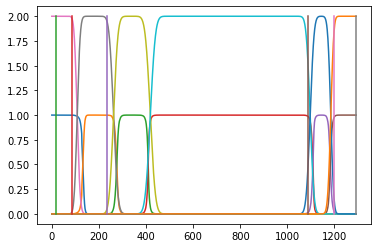

In [239]:
vidid = list(posterior_table.keys())[np.random.randint(len(posterior_table))]

for proba in posterior_table[vidid]:
    plt.plot(proba)
    
for proba in prior_table[vidid]:
    plt.plot(2*proba)
    
for bd in video_id_boundary_frames[vidid]:
    plt.plot([bd, bd], [0, 2])
print(video_id_boundary_frames[vidid])

In [33]:
print("Calculating Validation Data Accuracy")
correct = 0.0
total = 0.0
for i, item in enumerate(testloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)

        pred = torch.argmax(predictions[-1], dim=1)
        correct += float(torch.sum((pred == item_2) * src_mask).item())
        total += float(torch.sum(src_mask).item())

print(f"Validation:: Probability Accuracy {correct * 100.0 / total}")

Calculating Validation Data Accuracy
Validation:: Probability Accuracy 69.60005698208626


In [107]:
framewise_proba = prob[j].cpu()
ele = item[4][j]
frame_count = frame_id_dict[ele]
label_list = [label_name_to_label_id_dict[item] for item in weak_labels[ele]]
seqlen = len(label_list)
label_seq_prob = framewise_proba[:frame_count,label_list]
label_seq_logprob = torch.log(label_seq_prob + 1e-10)

left_probsum = torch.cumsum(label_seq_prob, dim=1)
right_probsum = torch.sum(label_seq_prob, dim=1, keepdim=True) - torch.cumsum(label_seq_prob, dim=1) + label_seq_prob

left_logprobsum = torch.log(torch.clip(left_probsum, min=1e-20))
right_logprobsum = torch.log(torch.clip(right_probsum, min=1e-20))

left_logprobsum_left_idsum = torch.cumsum(left_logprobsum, dim=0)
left_logprobsum_left_idsum -= left_logprobsum
right_logprobsum_right_idsum = torch.sum(right_logprobsum, dim=0, keepdim=True) - torch.cumsum(right_logprobsum, dim=0)

for k in range(seqlen):
    left_logprobsum_left_idsum[:k,k] = -1000
    remaining_labelcount = seqlen-k-1
    if remaining_labelcount > 0:
        right_logprobsum_right_idsum[-remaining_labelcount:,k] = -1000

loglikelihood = label_seq_logprob + left_logprobsum_left_idsum + right_logprobsum_right_idsum
posterior = loglikelihood.T + torch.log(torch.clip(torch.tensor(prior_table[ele]), min=1e-10))
posterior = torch.softmax(posterior, dim=0)

In [116]:
model.eval()
for i, item in enumerate(trainloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)
        prob = torch.softmax(predictions[-1], dim=1)
        prob = prob.permute(0, 2, 1)
        for j in range(len(prob)):
            generate_posterior_loss_weights(prob[j].cpu(), item[4][j])

        if i%10==0:
            print(f'{i+1} iteration done')
get_boundary_err()

1 iteration done
11 iteration done
21 iteration done
31 iteration done
41 iteration done
51 iteration done
61 iteration done
71 iteration done
81 iteration done
91 iteration done
101 iteration done
111 iteration done
121 iteration done
131 iteration done
141 iteration done
151 iteration done
161 iteration done
171 iteration done
181 iteration done
Train Boundary avergage error = 118.393
